In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.io
import torchvision.transforms as transforms
from torch.optim.swa_utils import AveragedModel
from torchvision.datasets import Flowers102

from lib.unet import UNet

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = [0.4750, 0.3940, 0.3079]
std = [0.2218, 0.2075, 0.2036]
transform = transforms.Compose([
    transforms.PILToTensor(),  # convert PIL image to PyTorch tensor
    transforms.Resize(128),  # resize the image to have a minimum size of 128x128 pixels
    transforms.CenterCrop(128),  # crop the image to 128x128 pixels around the center
    transforms.ConvertImageDtype(torch.float32),  # convert the image to float32
    transforms.Normalize(mean, std)  # normalize so that data has zero mean and unit variance
])

test_data = Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform
)


def normalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    tensor = (tensor - mean) / std
    return tensor


def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, -1, 1, 1).to(tensor.device)
    tensor = tensor * std + mean  # the transform applies this in reverse
    return tensor.clamp(0, 1)

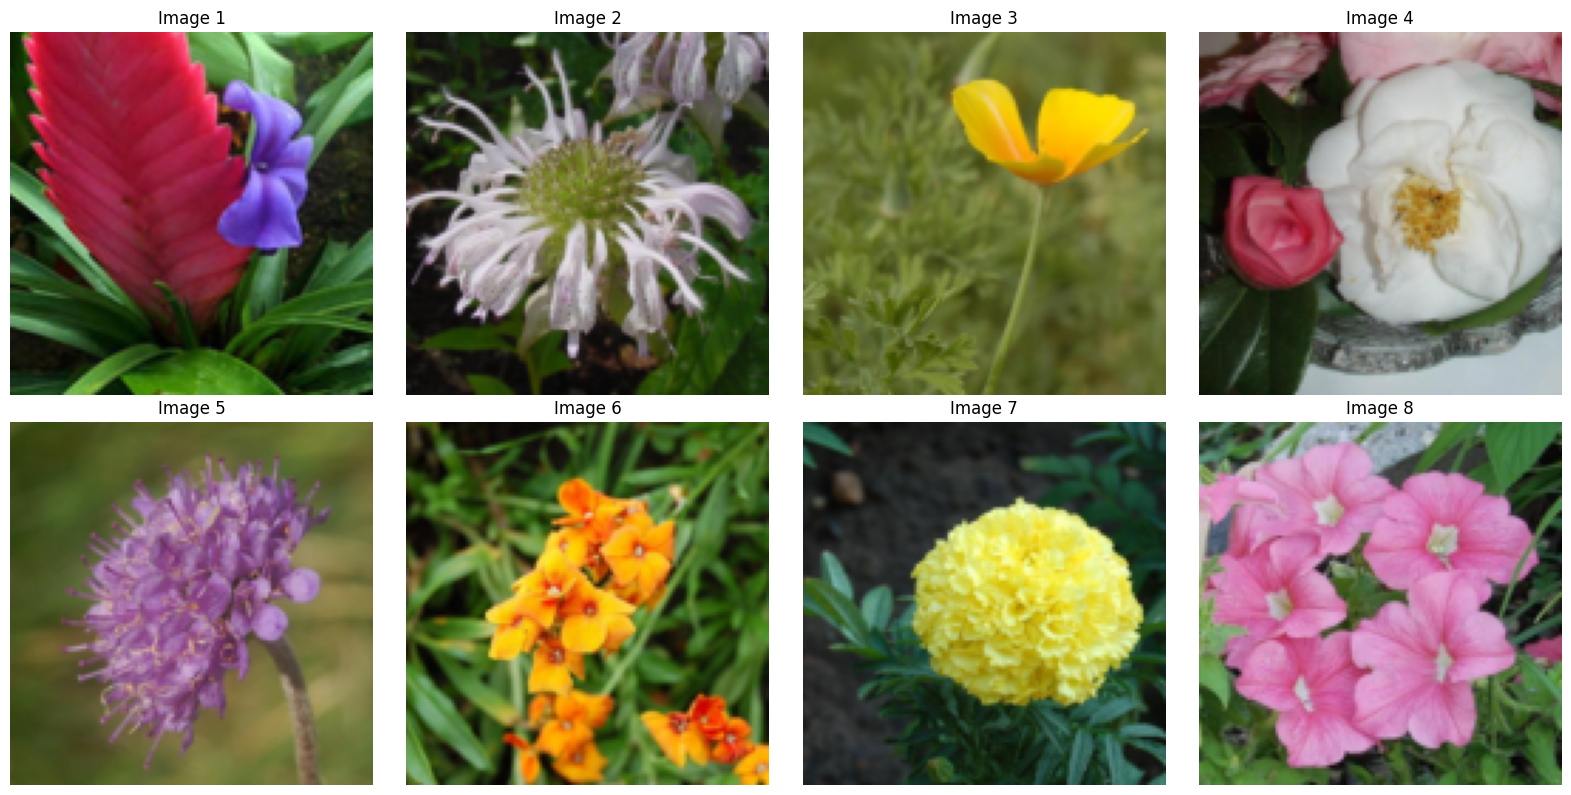

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    sample_img, _ = test_data[sample_idx]
    sample_img = denormalize(sample_img.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(sample_img.permute(1, 2, 0))  # (C, W, H) -> (W, H, C)
    ax.set_title(f"Image {i + 1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [4]:
def cosine_diffusion_schedule(diffusion_times, device):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.acos(torch.tensor(max_signal_rate, device=device))
    end_angle = torch.acos(torch.tensor(min_signal_rate, device=device))

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

In [5]:
T = 8  # timestep at which the image is complete noise

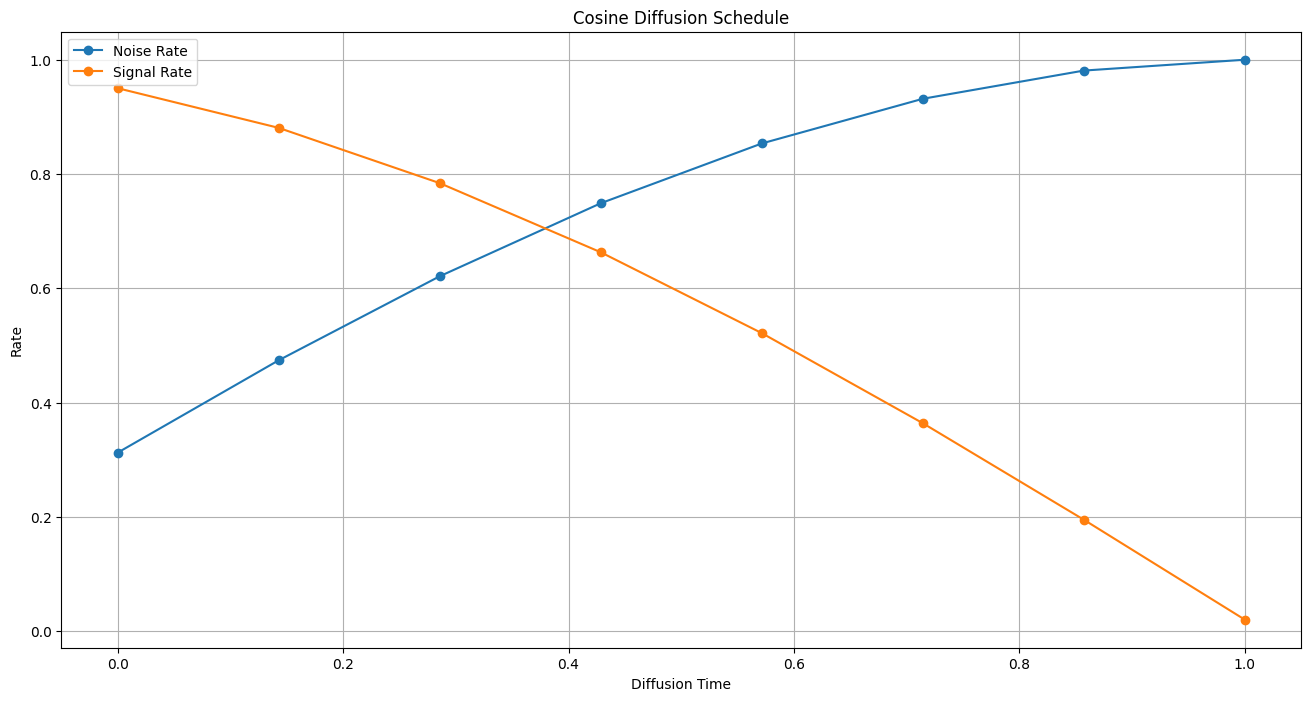

In [6]:
t_array = torch.linspace(0, 1, T)
noise_rates, signal_rates = cosine_diffusion_schedule(t_array, device="cpu")
plt.figure(figsize=(16, 8))
plt.plot(t_array.numpy(), noise_rates.numpy(), label='Noise Rate', marker='o')
plt.plot(t_array.numpy(), signal_rates.numpy(), label='Signal Rate', marker='o')
plt.title('Cosine Diffusion Schedule')
plt.xlabel('Diffusion Time')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

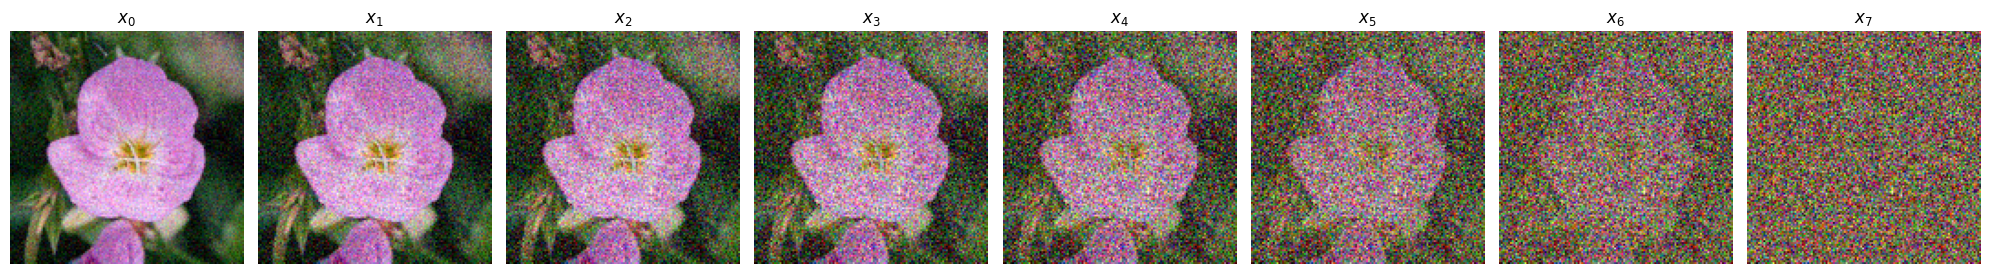

In [7]:
x_0, _ = test_data[0]
x_t_list = []  # noisy images
gaussian_noise = torch.randn_like(x_0)  # noise with zero mean and unit variance with the same shape as image

# Create the noisy images
for t in range(len(t_array)):
    x_t = signal_rates[t] * x_0 + noise_rates[t] * gaussian_noise
    x_t_list.append(x_t)

fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(axes.flatten()):
    x_t = x_t_list[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0))
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

In [8]:
image_shape = (3, 128, 128)
model = UNet(
    in_shape=image_shape,
    out_shape=image_shape,
    features=[64, 128, 256, 512, 1024],
    embedding_dim=64
).to(device)
ema_model = AveragedModel(
    model,
    multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.999),
    device=device
)
ema_model.load_state_dict(torch.load("model.pt", map_location=device))
ema_model.eval()
print("Model loaded successfully")

Model loaded successfully


In [9]:
def denoise(model, noisy_images, noise_rates, signal_rates):
    predicted_noises = model(noisy_images, noise_rates ** 2)
    predicted_images = (noisy_images - noise_rates * predicted_noises) / signal_rates
    return predicted_noises, predicted_images

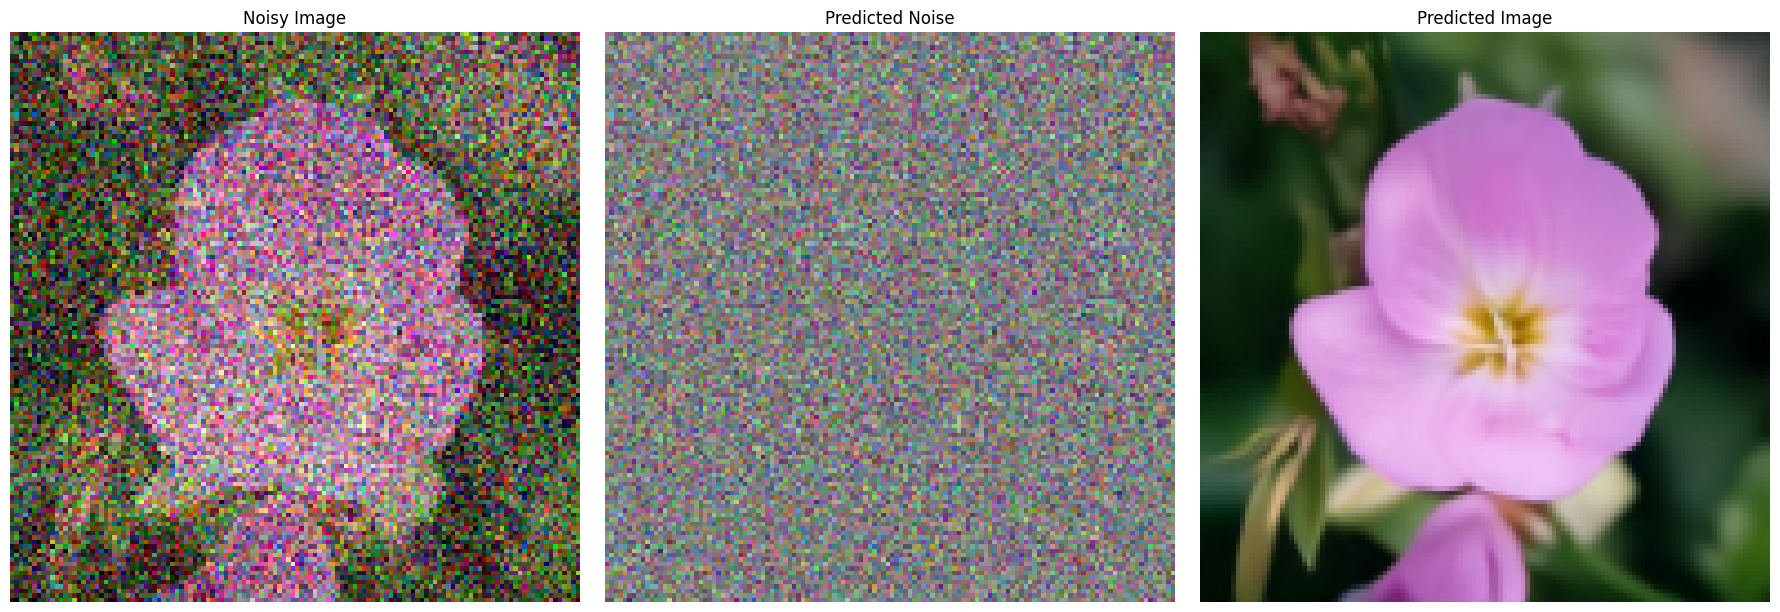

In [10]:
timestep = 4
x_t = x_t_list[timestep].unsqueeze(0).to(device)  # add a batch dimension (1, 3, 128, 128)

with torch.no_grad():
    pred_noise, pred_image = denoise(ema_model, x_t, noise_rates[timestep], signal_rates[timestep])

noisy_image = denormalize(x_t, mean, std)
pred_image = denormalize(pred_image, mean, std)

# Normalize the predicted noise to [0, 1] for visualization
pred_noise_img = pred_noise.squeeze(0)
pred_noise_min = pred_noise_img.min()
pred_noise_max = pred_noise_img.max()
pred_noise_img = (pred_noise_img - pred_noise_min) / (pred_noise_max - pred_noise_min)

# Create a figure with 3 subplots for the noisy image, predicted noise, and predicted image
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Noisy Image")
axes[0].axis("off")

axes[1].imshow(pred_noise_img.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Predicted Noise")
axes[1].axis("off")

axes[2].imshow(pred_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[2].set_title("Predicted Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()

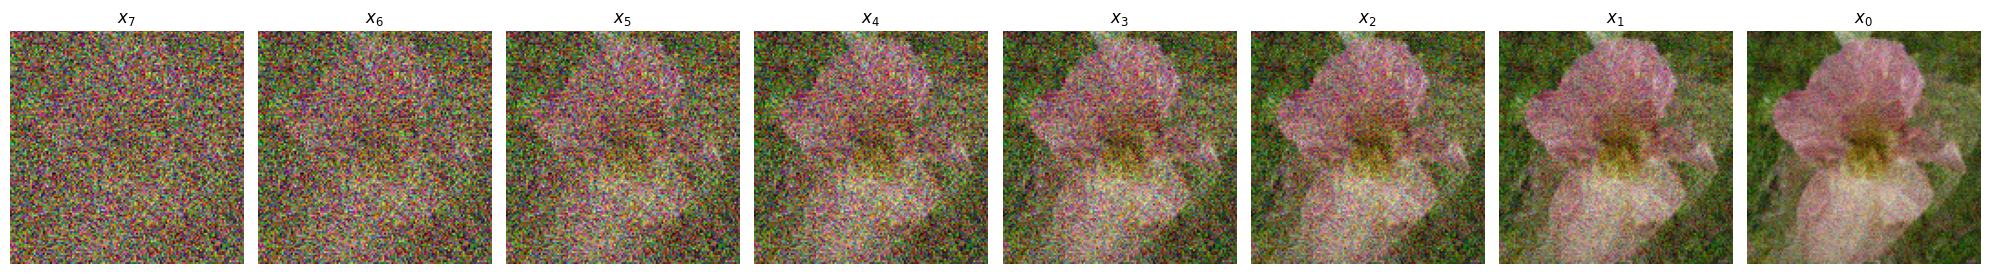

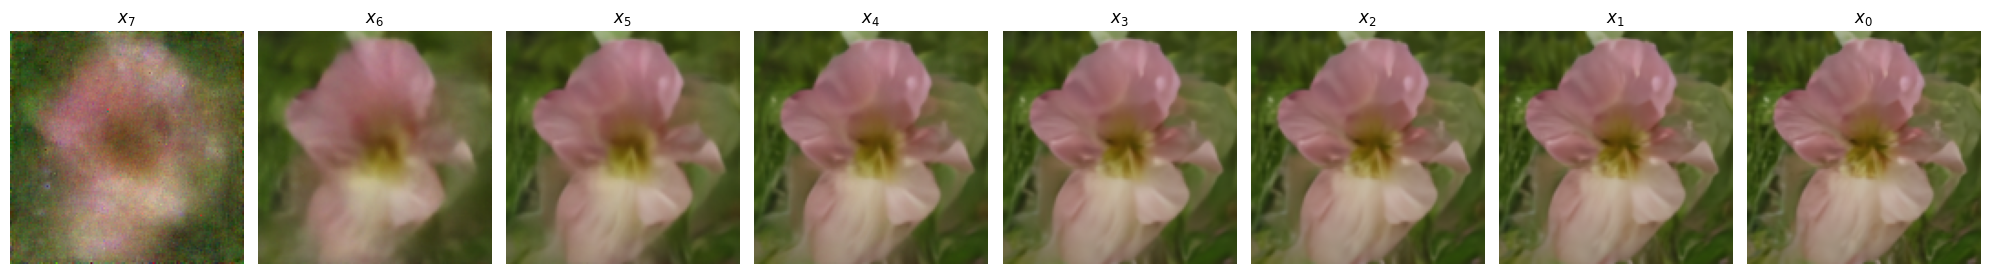

In [13]:
gaussian_noise = torch.randn(1, *image_shape, device=device)  # x_T but pure noise
step_size = 1.0 / T

x_t_reverse_diffusion_list = []
predicted_images = []

next_x_t = gaussian_noise
for step in range(T):
    x_t = next_x_t

    t = torch.ones((1, 1, 1, 1), device=device) - step * step_size
    noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
    with torch.no_grad():
        pred_noise, pred_image = denoise(ema_model, x_t, noise_rate, signal_rate)

    next_t = t - step_size
    next_noise_rate, next_signal_rate = cosine_diffusion_schedule(next_t, device)
    next_x_t = next_signal_rate * pred_image + next_noise_rate * pred_noise

    x_t_reverse_diffusion_list.insert(0, next_x_t.squeeze(0))
    predicted_images.insert(0, pred_image.squeeze(0))

# display the diffusion steps
fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(reversed(axes.flatten())):
    x_t = x_t_reverse_diffusion_list[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0).cpu().numpy())
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

# display the predicted images
fig, axes = plt.subplots(1, T, figsize=(20, 5))
for i, ax in enumerate(reversed(axes.flatten())):
    x_t = predicted_images[i]
    x_t = denormalize(x_t.unsqueeze(0), mean, std).squeeze(0)
    ax.imshow(x_t.permute(1, 2, 0).cpu().numpy())
    ax.set_title(fr'$x_{i}$')
    ax.axis("off")
plt.tight_layout()
plt.show()

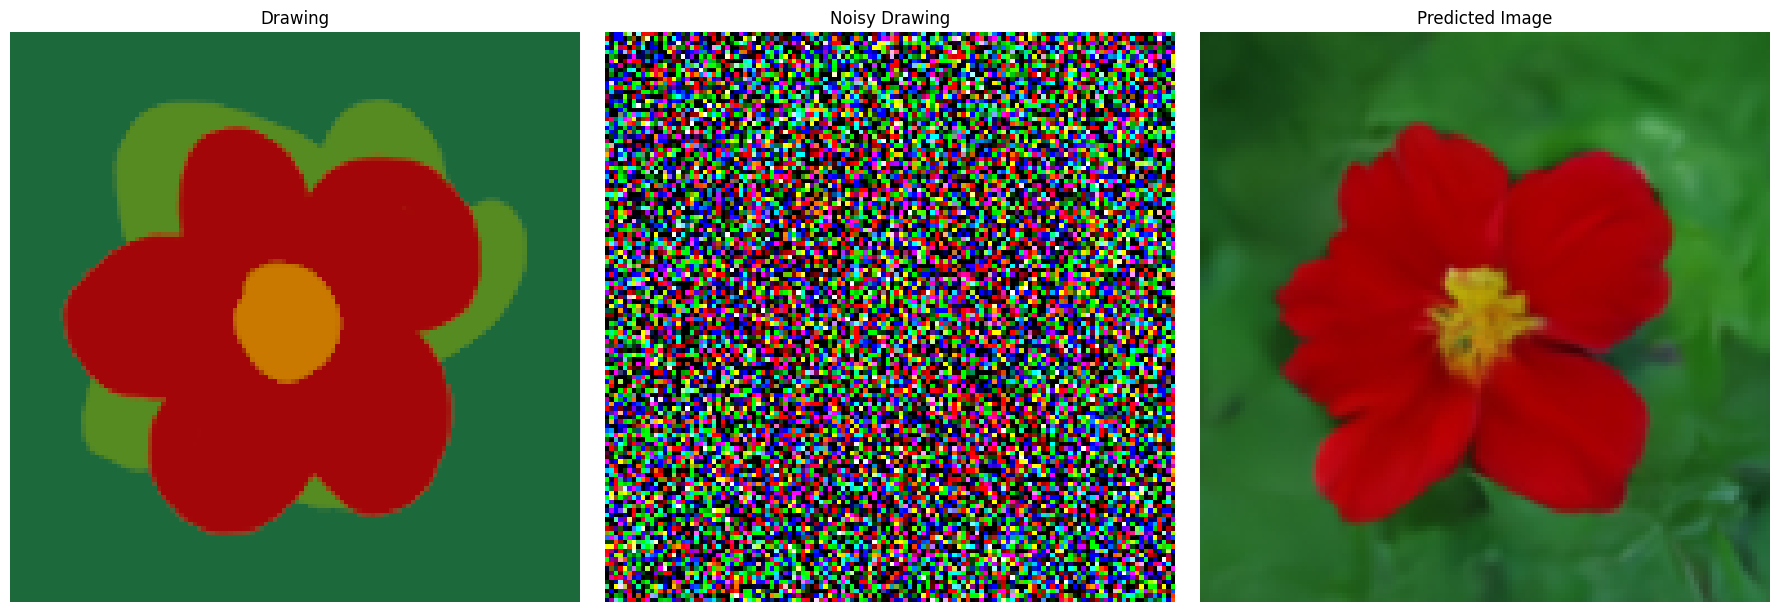

In [18]:
strength = 0.95
step_size = strength / T

# load drawing
drawing = torchvision.io.read_image("docs/drawing.png").float() / 255.0

# add batch dimension and send to device
drawing = drawing.unsqueeze(0).to(device)

# normalize the drawing
drawing = normalize(drawing, mean, std)

# apply the noise
gaussian_noise = torch.randn(1, *image_shape, device=device)
t = torch.full((1, 1, 1, 1), strength, device=device)
noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
noisy_drawing = signal_rate * drawing + noise_rate * gaussian_noise

next_x_t = noisy_drawing
for step in range(T):
    x_t = next_x_t

    t = torch.full((1, 1, 1, 1), strength, device=device) - step * step_size
    noise_rate, signal_rate = cosine_diffusion_schedule(t, device)
    with torch.no_grad():
        pred_noise, pred_image = denoise(ema_model, x_t, noise_rate, signal_rate)

    next_t = t - step_size
    next_noise_rate, next_signal_rate = cosine_diffusion_schedule(next_t, device)
    next_x_t = next_signal_rate * pred_image + next_noise_rate * pred_noise

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

drawing = denormalize(drawing, mean, std)
pred_image = denormalize(pred_image, mean, std)

axes[0].imshow(drawing.clip(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[0].set_title("Drawing")
axes[0].axis("off")

axes[1].imshow(noisy_drawing.clip(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[1].set_title("Noisy Drawing")
axes[1].axis("off")

axes[2].imshow(pred_image.clip(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy())
axes[2].set_title("Predicted Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()